<a href="https://colab.research.google.com/github/fcastellanosp/MINE-4210_202420_ADL/blob/main/Laboratorios/Laboratorio%202/MINE4210_ADL2024_Lab2_S3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo ADL](https://github.com/fcastellanosp/MINE-4210_202420_ADL/blob/main/Laboratorios/logo_adl.png?raw=true)

**Tutores**.
* Nicolás Tibatá Casteñeda.
* Fabián Camilo Castellanos P.

#Tabla de contenido

[Contexto y objetivos.](#scrollTo=vRly1LFxSTUK)<br>
[Entendimiento del negocio.](#scrollTo=fmyH8DbnKP4V)<br>
[0. Instalación de librerías.](#scrollTo=w5ftYtL_KSyF)<br>
[1. Importar librerías](#scrollTo=6CXsKnA6KV8c)<br>
[2. Introducción a los datos.](#scrollTo=Ydis_lePKZLF)<br>
[3. Modelamiento.](#scrollTo=4QThQj9AKcjm)<br>
[4. Preguntas.](#scrollTo=HpYj05R_Kf5F)<br>

# **Laboratorio 2 - Sesión 3**
## **Redes Convolucionales**

## **Objetivos**
*  Construcción de una red para clasificación y localización.
*  Uso de modelos pre-entrenados y ajuste fino.

## **Problema**
La universidad de los Andes ha sido contactada para apoyar el estudio de animales en diferentes puntos del mundo. Para lograr este propósito, han hecho llegar una serie de fotografías de diversos tipos de animales, las cuáles han sido tomadas en su mayoría con cámaras de celular. El objetivo consiste en construir una mecanismo que permita identificar en cada una de las fotografías la ubicación del animal, así como la clase a la que pertenece. Toda la información ha sido consolidada en el siguiente [enlace](https://www.kaggle.com/datasets/notaashman/multiclass-animal-detection).

# Entendimiento del negocio.

Para tener un mejor detalle sobre el comportamiento de la información, la organización ha dispuesto la información de la siguiente forma:

```python
Multi-Class Animal Detection.v1-yolov8.zip/
  train/
    images/
      a_image_1.png
      a_image_2.jpg
      .......    
    labels/
      a_image_1.txt
      a_image_2.txt
      .......
  valid/
    images/
      b_image_1.png
      b_image_2.jpg
      .......    
    labels/
      b_image_1.txt
      b_image_2.txt
      .......
  test/
    images/
      c_image_1.png
      c_image_2.jpg
      .......    
    labels/
      c_image_1.txt
      c_image_2.txt
      .......
```

Es importante tener en cuenta esta taxonomía, para las acciones que realizaremos más adelante.

# 0. Instalación de librerías
Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías:

In [1]:
!pip install ultralytics==8.2.98

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.6/235.7 GB disk)


En los laboratorios desarrollados hasta el momento, las librerías que hemos requerido para construir nuestros modelos, han sido instaladas vía PIP. Hoy, para cumplir el propósito de la organización, vamos a construir un modelo de identificación de objetos usando la librería **Yolo**, en su versión 8. Esta librería puede ser instalada de 2 formas, permite inyectar el código al notebook clonando directamente desde el repositorio de [Git](https://github.com/ultralytics/ultralytics) o vía PIP.

Para este notebook hemos hecho uso de la opción que instala la librería mediante este último: PIP.

---
# 1. Importar librerías

In [2]:
import pandas as pd
import numpy as np

import os
import os.path as osp
import random
import re
import shutil

#Visualización de datos
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.display import display, Image

from numpy import asarray

from PIL import Image

from ultralytics import YOLO

Este fragmento de código, nos permite evaluar si tenemos disponible una GPU dentro del ambiente de Google Colab:

In [3]:
!nvidia-smi

Sun Sep 22 21:53:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

---
# 2. Introducción a los datos.

##2.1. Parámetros generales y carga de la información.

In [4]:
my_seed = 19 #Semilla para reproducibilidad
IMG_EXT = ['.jpg', '.jpeg', '.png', '.bmp'] #Extensiones válidas de imagen
TEXT_EXT = '.txt'
YOLO_VERSION = 'yolov8'

In [5]:
random.seed(my_seed)

## 2.2. Configuración del entorno de kaggle.

Verificamos la conectividad con kaggle, usando un comando para ver una previsualización de datasets:

In [6]:
!ls -lha kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 69 Sep 22 21:53 kaggle.json


Verificamos la conectividad con kaggle, usando un comando para ver una previsualización de datasets:

In [7]:
!kaggle datasets list

ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
lainguyn123/student-performance-factors                          Student Performance Factors                          94KB  2024-09-02 10:53:57          12189        259  1.0              
owm4096/laptop-prices                                            Laptop Prices                                        25KB  2024-09-09 12:43:01           2946         53  1.0              
waqi786/global-black-money-transactions-dataset                  🕵️‍♂️ Global Black Money Transactions Dataset 📊     298KB  2024-09-15 10:56:34           1094         22  1.0              
taweilo/mba-admission-dataset                          

Una vez hemos asegurado la conectividad, procedemos a realizar el proceso de descarga de la información del negocio.

In [8]:
!kaggle datasets download notaashman/multiclass-animal-detection

Dataset URL: https://www.kaggle.com/datasets/notaashman/multiclass-animal-detection
License(s): unknown
 99% 108M/109M [00:06<00:00, 17.7MB/s]
100% 109M/109M [00:06<00:00, 16.4MB/s]


## 2.3. Preparación de datos.

Para la información que vamos a descomprimir, es necesario crear un un directorio para que el contenido del archivo zip, se encuentre allí. Para este propósito, vamos a crear unas variables de manejo de archivos:

In [9]:
ROOT_DIR = '/content'
DATASET_NAME = 'multiclass-animal-detection'
SUB_DATASET_NAME = 'Multi-Class Animal Detection.v1-yolov8'

Vamos ahora a generar una previsualización del comando de descompresión del archivo zip:

In [10]:
print(f"!unzip {DATASET_NAME}.zip -d {ROOT_DIR}/{DATASET_NAME}")

!unzip multiclass-animal-detection.zip -d /content/multiclass-animal-detection


Ahora si vamos a consolidar el bloque de comandos con todos los pasos para la descompresión del archivo zip:

In [11]:
%cd {ROOT_DIR}
!mkdir /{DATASET_NAME}
!unzip {DATASET_NAME}.zip -d {ROOT_DIR}/{DATASET_NAME}

/content
Archive:  multiclass-animal-detection.zip
  inflating: /content/multiclass-animal-detection/Multi-Class Animal Detection.v1-yolov8/data.yaml  
  inflating: /content/multiclass-animal-detection/Multi-Class Animal Detection.v1-yolov8/test/images/Elephant-1-_png.rf.197cced44d9cfaea3712a2c2bdf0a983.jpg  
  inflating: /content/multiclass-animal-detection/Multi-Class Animal Detection.v1-yolov8/test/images/Elephant-13-_jpeg.rf.94584f74c05165c2528ed4ec0ef91e6d.jpg  
  inflating: /content/multiclass-animal-detection/Multi-Class Animal Detection.v1-yolov8/test/images/Elephant-15-_jpeg.rf.bfa60d96a67a18ea411c08d75b3bac71.jpg  
  inflating: /content/multiclass-animal-detection/Multi-Class Animal Detection.v1-yolov8/test/images/Elephant-19-_jpeg.rf.3d9be22392097794f1c9c78dbe168295.jpg  
  inflating: /content/multiclass-animal-detection/Multi-Class Animal Detection.v1-yolov8/test/images/Elephant-2-_png.rf.8a010600e8678c491e09eefd234aa333.jpg  
  inflating: /content/multiclass-animal-detecti

Generamos la ruta del directorio para cargar la información:

In [12]:
DATA_DIR = f"{ROOT_DIR}/{DATASET_NAME}/{SUB_DATASET_NAME}"
print(DATA_DIR)

/content/multiclass-animal-detection/Multi-Class Animal Detection.v1-yolov8


Verificamos las rutas de cada uno de los directorios:

In [13]:
subdirs = ['train', 'test', 'valid']

In [14]:
train_folder = osp.join(DATA_DIR, subdirs[0])
train_img_folder = osp.join(train_folder, "images")
train_lbl_folder = osp.join(train_folder, "labels")
val_folder = osp.join(DATA_DIR, subdirs[2])
val_img_folder = osp.join(val_folder, "images")
val_lbl_folder = osp.join(val_folder, "labels")
test_folder = osp.join(DATA_DIR, subdirs[1])
test_img_folder = osp.join(test_folder, "images")
test_lbl_folder = osp.join(test_folder, "labels")

Vamos a visualizar las rutas de las carpetas:

In [15]:
folder_list = [train_img_folder, train_lbl_folder,
                val_img_folder, val_lbl_folder,
                test_img_folder, test_lbl_folder
]

print("Imprimimos las rutas de las carpetas:")
for fa in folder_list:
  print(fa)
  print(f"¿La ruta es válida?: {osp.exists(fa)}")

Imprimimos las rutas de las carpetas:
/content/multiclass-animal-detection/Multi-Class Animal Detection.v1-yolov8/train/images
¿La ruta es válida?: True
/content/multiclass-animal-detection/Multi-Class Animal Detection.v1-yolov8/train/labels
¿La ruta es válida?: True
/content/multiclass-animal-detection/Multi-Class Animal Detection.v1-yolov8/valid/images
¿La ruta es válida?: True
/content/multiclass-animal-detection/Multi-Class Animal Detection.v1-yolov8/valid/labels
¿La ruta es válida?: True
/content/multiclass-animal-detection/Multi-Class Animal Detection.v1-yolov8/test/images
¿La ruta es válida?: True
/content/multiclass-animal-detection/Multi-Class Animal Detection.v1-yolov8/test/labels
¿La ruta es válida?: True


In [16]:
folder_list = [train_img_folder, val_img_folder,
               test_img_folder
]

¿Necesitamos usar los tensores?, no en este caso, dado que la información ya está descargada, vamos a asegurar la taxonomía de la información que espera Yolo.

¿Debemos validar el tamaño de las imágenes?. Normalmente debe hacerse, para este proceso es posible hacer un recorrido sobre los archivos y contrastar con los metadatos. Como en este caso no ha sido suministrado por la organización, no realizaremos este proceso cruzado, imprimimos la información directamente desde las imágenes:

In [17]:
img_name_list = []
img_width_list = []
img_height_list = []
img_folder_list = []
img_format_list = []

for fa in folder_list:
  parent = os.path.dirname(fa)
  parent_name = os.path.basename(parent)
  for fname in os.listdir(fa):
    img_folder_list.append(parent_name)
    img_name_list.append(fname)
    img_path = osp.join(fa, fname)
    img_format_list = "ok" if osp.splitext(fname)[-1] in IMG_EXT else "not ok"

    with Image.open(img_path) as img:
      width, height = img.size
      img_width_list.append(width)
      img_height_list.append(height)

data_model = {"folder": img_folder_list, "image_name": img_name_list,
              "width": img_width_list, "height": img_height_list
              , "format": img_format_list}
report_df = pd.DataFrame(data=data_model)

In [18]:
report_df.head()

folder                                         image_name  width  height  \
0  train  panda-90-_jpg.rf.15c13ef6c0692fb9ca6e3c6d00af4...    640     640   
1  train  gorilla-186-_jpeg.rf.7e569aa319a8b9635f50ebb65...    640     640   
2  train  rat-25-_jpg.rf.7dd4545f7139bb0e880c17afdaeaea5...    640     640   
3  train  wolf-74-_jpg.rf.e367bd723425a9bbc25c47d661fb23...    640     640   
4  train  Elephant-20-_JPG.rf.c830544eaf8363d33c7940b848...    640     640   

  format  
0     ok  
1     ok  
2     ok  
3     ok  
4     ok

Este pequeño gragmento del reporte nos demuestra una longitud importante en cuánto a los nombres de los archivos, en la medida que nos sea posible estaremos "truncando" los nombres para faciliar la presentación de la información.

In [19]:
report_df.groupby(['folder', 'format', 'width', 'height']).size()

folder  format  width  height
test    ok      640    640        300
train   ok      640    640       1400
valid   ok      640    640        300
dtype: int64

Con el anterior reporte, hemos podido confirmar para cada uno de los conjuntos de datos, cuáles son los tamaños de las imágenes, además si los archivos son válidos, ya que en caso de tener imágenes que no se puedan abrir o un archivo con extensión no válida, pueden ser un inconveniente en la construcción del modelo.

In [20]:
IMAGE_SIZE = 640

Vamos a definir una función que permita visualizar muestras de los datos

In [21]:
def show_img_matrix(image_list, show_axis=False):
  MAX_SIZE = 9
  if len(image_list) != MAX_SIZE:
    return

  plt.figure(figsize=(10, 10))

  for i in range(MAX_SIZE):
    img_file = image_list[i]
    img_name = osp.basename(img_file)
    ax = plt.subplot(3, 3, i + 1)
    if osp.exists(img_file) == True:
      plt.imshow(asarray(Image.open(img_file)))
      img = mpimg.imread(img_file)
    #Como los nombres son muy extensos, vamos a truncar a 20 caracteres.
    plt.title(img_name[:20])
    plt.axis("on" if show_axis == True else "on")

  plt.tight_layout()
  plt.show()

Podemos observar que la función anterior cuenta con un parámetro que permite controlar la visualización de los ejes en las imágenes. En caso que no sea especificado, no los mostrará en la matriz.

Preparamos la carpeta para los datos de entrenamiento:

In [22]:
img_list = [filename for filename in os.listdir(train_img_folder)]
img_count = len(img_list)
print(f"El número total de imágenes es: {img_count}")

El número total de imágenes es: 1400


In [23]:
random.shuffle(img_list)

In [24]:
img_fc_list = [osp.join(train_img_folder, filename) for filename in img_list]

Visualizamos la información de una muestra de los datos de entrenamiento:

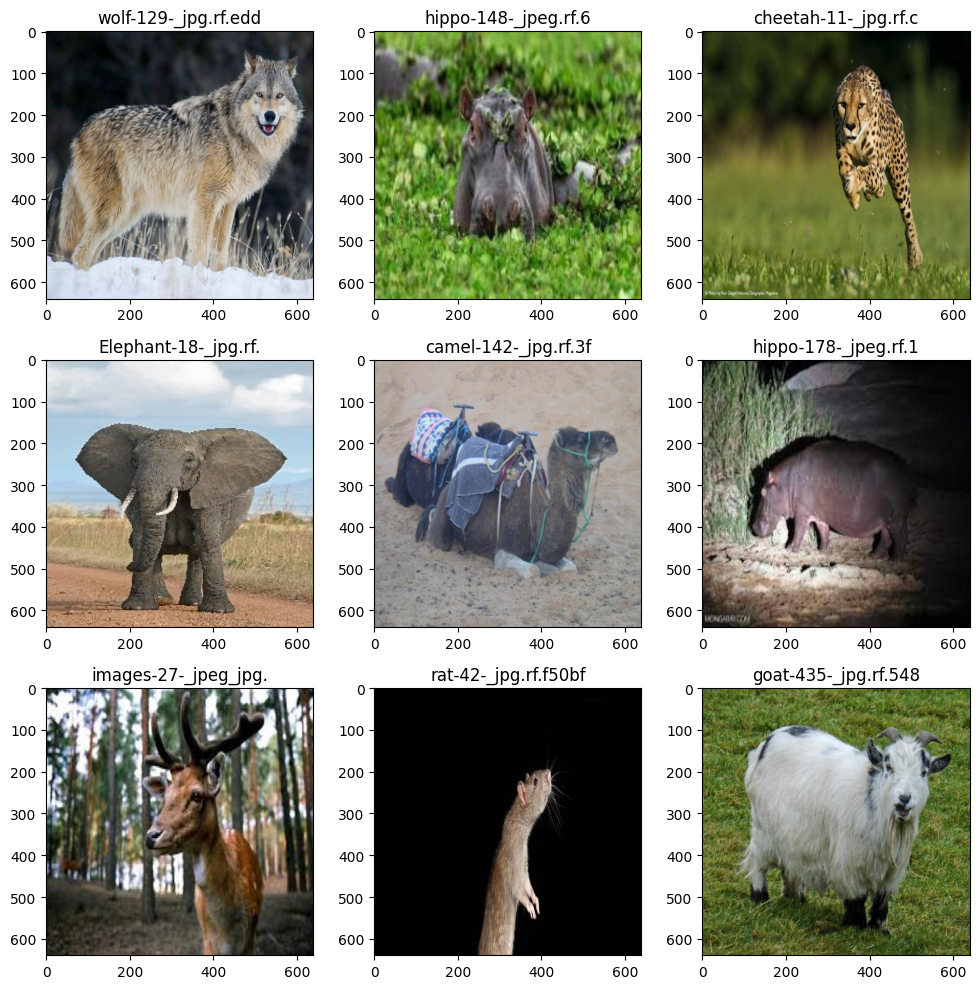

In [25]:
show_img_matrix(img_fc_list[0:9], show_axis=True)

---
# 3. Modelamiento.

## 3.1.Arquitectura de la red.

Yolo es un algoritmo de detección de objetos desarrollado por Ultralytics basado en pytorch.

Yolo gramaticalmente significa **You Only Look Once**, el cuál está basado en redes neuronales convolucionales (CNN).

La primera versión de Yolo fue liberada en el año 2015, la versión 5 en el año 2020 y la 6 en el año 2022. Actualmente existe la número 10, pero para entendimiento del modelo usaremos la número 6 para ir en línea del programa del curso:

![Arquitectura Yolov8](https://github.com/fcastellanosp/MINE-4210_202420_ADL/blob/main/Laboratorios/Laboratorio%202/images/yolo_simple_architecture.png?raw=true)

La estructura principal de esta red convolucional (CNN) YOLOv8, está dividida en las siguientes 3 partes:

*   **Backbone**: En español sería columna vertebral, para Yolo corresponde al cuerpo principal de la red. Tiene el rol de extractor de características. Con respecto a su versión predecesora, tiene un mejor de desempeño y aprovechamiento de la GPU.
*   **Neck**: En español sería cuello, al igual que el cuerpo humano permitiría conectar la columna vertebral con la cabeza. Tiene el rol de extraer características más detalladas. En cuánto a su versión predecesora, tiene un mejor equilibrio entre desempeño y velocidad.
*   **Head**: En español sería la cabeza, la cuál es responsable de generar la salida final.

Para el caso del **Head** no hay cambios desde la versión de YOLOv3.

En los modelos de detección, a diferencia de los laboratorios anteriores, la detección de objetos requiere para cada una de las imágenes, especificar la clase y las coordenadas de los objetos de las imágenes que representa.

De esta forma estará en capacidad de identificar los objetos, como por ejemplo la ficha de ajedrez reina de cada jugador:

![Yolov8 Neck](https://github.com/fcastellanosp/MINE-4210_202420_ADL/blob/main/Laboratorios/Laboratorio%202/images/yolo_example.png?raw=true)

Tiene la capacidad incluso de detectar objetos en videos:

![Arquitectura Yolov8](https://miro.medium.com/v2/resize:fit:786/format:webp/1*r7zLjRFngk8KbgHxO-k_wA.gif)

> Imagen tomada del repositorio git del autor *ibaiGorordo*.

## 3.2. Taxonomía.

*Yolo* ha sido desarrollado para leer la información de las imágenes y las etiquetas que cuentan con la información de las clases a identificar y las coordenadas de los bounding box (localización de la clase en la imagen correspondiente).

**Carpeta de Imágenes**: Contiene todas las imágenes en las que deseas entrenar el modelo. Por lo general, esta carpeta normalmente es nombrada como `images`.

**Carpeta de Anotaciones**: Para cada imagen en la carpeta de imágenes, necesitas una anotación que describa la ubicación y la clase de los objetos que se encuentran en la imagen. Estas anotaciones se almacenan en archivos de texto. Por lo general, esta carpeta normalmente es nombrada como `labels`.

Dado que este modelo requiere una taxonomía apropiada para su funcionamiento, por lo tanto en el primer nivel deben estar las carpetas de las imágenes y las etiquetas. Al interior de cada una de ellas deberá estar los conjuntos de entrenamiento, validación y test.

Para entenderlo mejor, este esquema o taxonomía, se vería de la siguiente forma:

```python
dataset/
  images/
    train/
      a_image_1.jpg
      a_image_2.jpg  
    val/
      a_image_3.jpg
      a_image_4.jpg
    test/
      a_image_5.jpg
      a_image_6.jpg        
  labels/        
    train/
      a_image_1.txt
      a_image_2.txt  
    val/
      a_image_3.txt
      a_image_4.txt
    test/
      a_image_5.txt
      a_image_6.txt        
```

De esta forma, para el conjunto de entrenamiento, la imagen cuyo nombre es `a_image_1.jpg`, tendrá su etiquetas en el archivo `a_image_1.txt`, hagamos  zoom a esta imagen y etiqueta en en la taxonomía:

```python
dataset/
  images/
    train/
      a_image_1.jpg        
  labels/        
    train/
      a_image_1.txt        
```

Las anotaciones requieren un `formato específico` para ser interpretados apropiadamente en Yolo, como allí encontraremos la información de la clase y el bounding box. Debemos tener en cuenta que este archivo debe tener tantas líneas, como objetos estén presentes en la imagen, a su vez, cada línea debe contar con la información de la clase, las coordenadas del centro del objeto, el ancho y el alto.

Su representación general, es la siguiente:

> `class_id x_center y_center width height`

La explicación de cada uno de los elementos, es la siguiente:

* La primera posición (`class_id`) representa el *identificador* de la clase etiquetada.
* La segunda posición (`x_center`)  representa la coordenada `x` del centro del objeto.
* La tercera posición (`y_center`) representa la coordenada `y` del centro del objeto.
* La cuarta posición (`width`) representa el ancho del recuadro (bounding box).
* La quinta posición (`height`) representa el alto del recuadro (bounding box).

Ahora veamos un ejemplo con esta estructura para entenderlo mejor.

`0 0.277 0.16 0.15 0.17714285714285713`

Si la imagen cuenta con 2 o más objetos, cada línea del archivo representará un objeto en la imagen.

Debe tenerse en cuenta que las coordenadas deben estar normalizadas es decir con valores entre cero a uno.

Aplicado a nuestro caso, los datos suministrados por la organización corresponden a animales, por lo tanto, la información de las clases estará asociado a ellos:

1. Buffalo (Búfalo).
2. Camel (Camello).
3. Cat (Gato).
4. Cheetah (Guepardo).
5. Cow (Vaca).
6. Deer (Ciervo).
7. Dog (Perro).
8. Elephant (Elefante).
9. Goat (Cabra).
10. Gorilla (Gorila).
11. Hippo (Hipopótamo).
12. Horse (Caballo).
13. Lion (León).
14. Monkeys (Monos).
15. Panda (Panda).
16. Rat (Rata).
17. Rhino (Rinoceronte).
18. Tiger (Tigre).
19. Wolf (Lobo).
20. Zebra (Cebra).

Normalmente los códigos inician en cero, por eso en nuestro caso el código `0` será `Buffalo` y el `19` será `Zebra`. Vamos a almacenar las clases en una variable:

In [26]:
class_names = ["Buffalo", "Camel", "Cat", "Cheetah", "Cow",
               "Deer", "Dog", "Elephant", "Goat", "Gorilla",
               "Hippo", "Horse", "Lion", "Monkey", "Panda",
               "Rat", "Rhino", "Tiger", "Wolf", "Zebra"
]

¿Tenemos los datos en la taxonomía que Yolo espera?, `No`, procedemos a organizar la información en un nuevo directorio:

In [27]:
NEW_ROOT_DIR = f"{ROOT_DIR}/{DATASET_NAME}-Cleaned"
print(DATA_DIR)

/content/multiclass-animal-detection/Multi-Class Animal Detection.v1-yolov8


In [28]:
print(f"Los datos para procesar en Yolo, serán copiados en la siguiente ruta: {DATA_DIR}")

Los datos para procesar en Yolo, serán copiados en la siguiente ruta: /content/multiclass-animal-detection/Multi-Class Animal Detection.v1-yolov8


In [29]:
subdirs = ['train', 'test', 'val']
new_train_folder = osp.join(NEW_ROOT_DIR, "images", subdirs[0])
new_val_folder = osp.join(NEW_ROOT_DIR, "images", subdirs[2])
new_test_folder = osp.join(NEW_ROOT_DIR, "images", subdirs[1])

img_tvt_folders = [train_img_folder, val_img_folder, test_img_folder]
new_img_tvt_folders = [new_train_folder, new_val_folder, new_test_folder]

In [30]:
for folder_path in new_img_tvt_folders:
  if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [31]:
for folder_path in new_img_tvt_folders:
  folder_path = folder_path.replace("/images", "/labels")
  if not os.path.exists(folder_path):
    os.makedirs(folder_path)

Copiamos la información en la estructura que yolo espera:

In [32]:
for i in range(len(img_tvt_folders)):
  old_img_folder = img_tvt_folders[i]
  old_lbl_folder = img_tvt_folders[i].replace("/images", "/labels")
  new_lbl_folder = new_img_tvt_folders[i].replace("/images", "/labels")
  #Obtenemos el listado de archivos de la carpeta
  images = os.listdir(old_img_folder)
  #Los nombres del archivo de imagen y las etiquetas se diferencian por la extensión del archivo
  for img in images:
    #Información del origen de la imagen
    old_img_path = osp.join(old_img_folder, img)
    name, ext = os.path.splitext(old_img_path) #Extraemos la información del nombre y tipo del archivo
    old_lbl_path = osp.join(old_lbl_folder, img.replace(ext, TEXT_EXT))

    new_img_path = osp.join(new_img_tvt_folders[i], img)
    new_lbl_path = osp.join(new_lbl_folder, img.replace(ext, TEXT_EXT))

    if osp.exists(new_img_path) == True:
      os.remove(new_img_path)

    if osp.exists(new_lbl_path) == True:
      os.remove(new_lbl_path)

    #Copia la imagen
    shutil.copy(old_img_path, new_img_path)
    #Copia la etiqueta
    shutil.copy(old_lbl_path, new_lbl_path)

¿Estamos listos?, aún no, Yolo espera un archivo en formato YAML, que brinde la información sobre la información que acabamos de organizar, clases y otros.

In [33]:
YOLO_DIR = f'/content/{YOLO_VERSION}'

In [34]:
yaml_content = f"""\
path: {NEW_ROOT_DIR}   # Directorio raiz de los datos
train: images/{osp.basename(new_img_tvt_folders[0])}  # Ruta relativa a los datos de entrenamiento
val: images/{osp.basename(new_img_tvt_folders[1])}  # Ruta relativa a los datos de validacion
test: images/{osp.basename(new_img_tvt_folders[2])} # Ruta relativa a los datos de prueba

# Classes
nc: {len(class_names)}

names: {class_names}
"""

YAML_PATH = f'{NEW_ROOT_DIR}/animal-detection.yaml'

if osp.exists(YAML_PATH):
  os.remove(YAML_PATH)

# Guardar el archivo YAML
with open(YAML_PATH, 'w') as yaml_file:
  yaml_file.write(yaml_content)

## 3.3. Entrenamiento.

Teniendo en cuenta que hemos instalado Yolo con el comando PIP, la instancia el modelo debe ser cargado de la siguiente forma:

In [35]:
model = YOLO('yolov8n.yaml')
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 357MB/s]


Para entrenar el modelo, le damos la información del archivo YAML, el número de épocas, tamaño de la imagen y el batch. De forma opcional vamos a especificar el valor de la paciencia.

In [36]:
#El parámetro name dependiendo de la versión, podría ser necesario especificarlo para asegurar el nombre de la carpeta de los resultados.
model.train(data=YAML_PATH, epochs=50, imgsz=IMAGE_SIZE, batch=16, patience=2, name="train")

New https://pypi.org/project/ultralytics/8.2.99 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/multiclass-animal-detection-Cleaned/animal-detection.yaml, epochs=50, time=None, patience=2, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=

100%|██████████| 755k/755k [00:00<00:00, 72.5MB/s]


Overriding model.yaml nc=80 with nc=20

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/multiclass-animal-detection-Cleaned/labels/train... 1400 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1400/1400 [00:00<00:00, 1990.99it/s]


train: New cache created: /content/multiclass-animal-detection-Cleaned/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/multiclass-animal-detection-Cleaned/labels/val... 300 images, 1 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<00:00, 1055.37it/s]


val: New cache created: /content/multiclass-animal-detection-Cleaned/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.26G     0.9975      3.898      1.476         32        640: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]

                   all        300        412     0.0237      0.759      0.118     0.0807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.22G     0.9857      3.315      1.477         21        640: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

                   all        300        412      0.344      0.389      0.278       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.22G      1.057      2.899      1.507         26        640: 100%|██████████| 88/88 [00:25<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


                   all        300        412      0.321      0.441      0.324      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.21G      1.026      2.675      1.485         17        640: 100%|██████████| 88/88 [00:25<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]

                   all        300        412      0.407      0.481      0.403      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.21G      1.032      2.511      1.475         16        640: 100%|██████████| 88/88 [00:25<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        300        412      0.496      0.433      0.468      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.22G     0.9972      2.311      1.444         24        640: 100%|██████████| 88/88 [00:27<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        300        412      0.641      0.454      0.526      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.21G      1.001      2.231      1.449         23        640: 100%|██████████| 88/88 [00:27<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


                   all        300        412      0.637      0.497      0.555      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.21G     0.9875      2.157       1.43         29        640: 100%|██████████| 88/88 [00:26<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

                   all        300        412      0.547      0.517      0.551      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.23G     0.9676      2.041      1.417         31        640: 100%|██████████| 88/88 [00:24<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]

                   all        300        412      0.659       0.55      0.632       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.21G     0.9576      1.915      1.392         25        640: 100%|██████████| 88/88 [00:26<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

                   all        300        412      0.657      0.552      0.639      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.21G      0.935      1.824      1.383         25        640: 100%|██████████| 88/88 [00:28<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

                   all        300        412      0.721      0.565      0.673      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.21G     0.9206       1.77      1.377         32        640: 100%|██████████| 88/88 [00:27<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


                   all        300        412      0.648      0.664      0.697      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.22G     0.9227       1.73      1.372         26        640: 100%|██████████| 88/88 [00:25<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]

                   all        300        412      0.681      0.616      0.706      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.22G     0.8951       1.65      1.352         24        640: 100%|██████████| 88/88 [00:24<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

                   all        300        412      0.685      0.595      0.692       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.21G     0.9089      1.619      1.359         25        640: 100%|██████████| 88/88 [00:27<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]

                   all        300        412       0.68      0.663      0.699      0.481
EarlyStopping: Training stopped early as no improvement observed in last 2 epochs. Best results observed at epoch 13, best model saved as best.pt.
To update EarlyStopping(patience=2) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



15 epochs completed in 0.131 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


                   all        300        412      0.683      0.615      0.706      0.481
               Buffalo         15         23      0.828      0.565      0.684      0.478
                 Camel         15         20      0.494      0.342      0.389      0.225
                   Cat         15         17      0.593      0.824      0.814      0.556
               Cheetah         15         25      0.826      0.758      0.806      0.452
                   Cow         15         17       0.58      0.882      0.848      0.578
                  Deer         15         15      0.986        0.6      0.742      0.546
                   Dog         15         17       0.75      0.824      0.823       0.56
              Elephant         15         23      0.786      0.522      0.707      0.513
                  Goat         15         22      0.536      0.727      0.728      0.503
               Gorilla         15         17      0.653      0.765      0.701      0.553
                 Hipp

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d2266778ee0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043

**NOTA**: En el caso que el notebook esté siendo ejecutado haciendo uso de la GPU, el modelo estará en capacidad de detectarla y de esta forma hará uso de ella, no es necesario especificarlo como si ocurre en Keras.

Yolo irá compilando la información de cada una de las ejecuciones de entrenamiento, validación y prueba, los cuáles debemos tener presente al momento de ir consultando los resultados.

La información la encontramos en la ruta que lleva valor *.../runs/detect/...*

Veamos una muestra de los datos que entrenamos:

In [37]:
Image.open(f'{ROOT_DIR}/runs/detect/train/val_batch0_pred.jpg')

Output hidden; open in https://colab.research.google.com to view.

Veamos la matriz de confusión para el modelo entrenado:

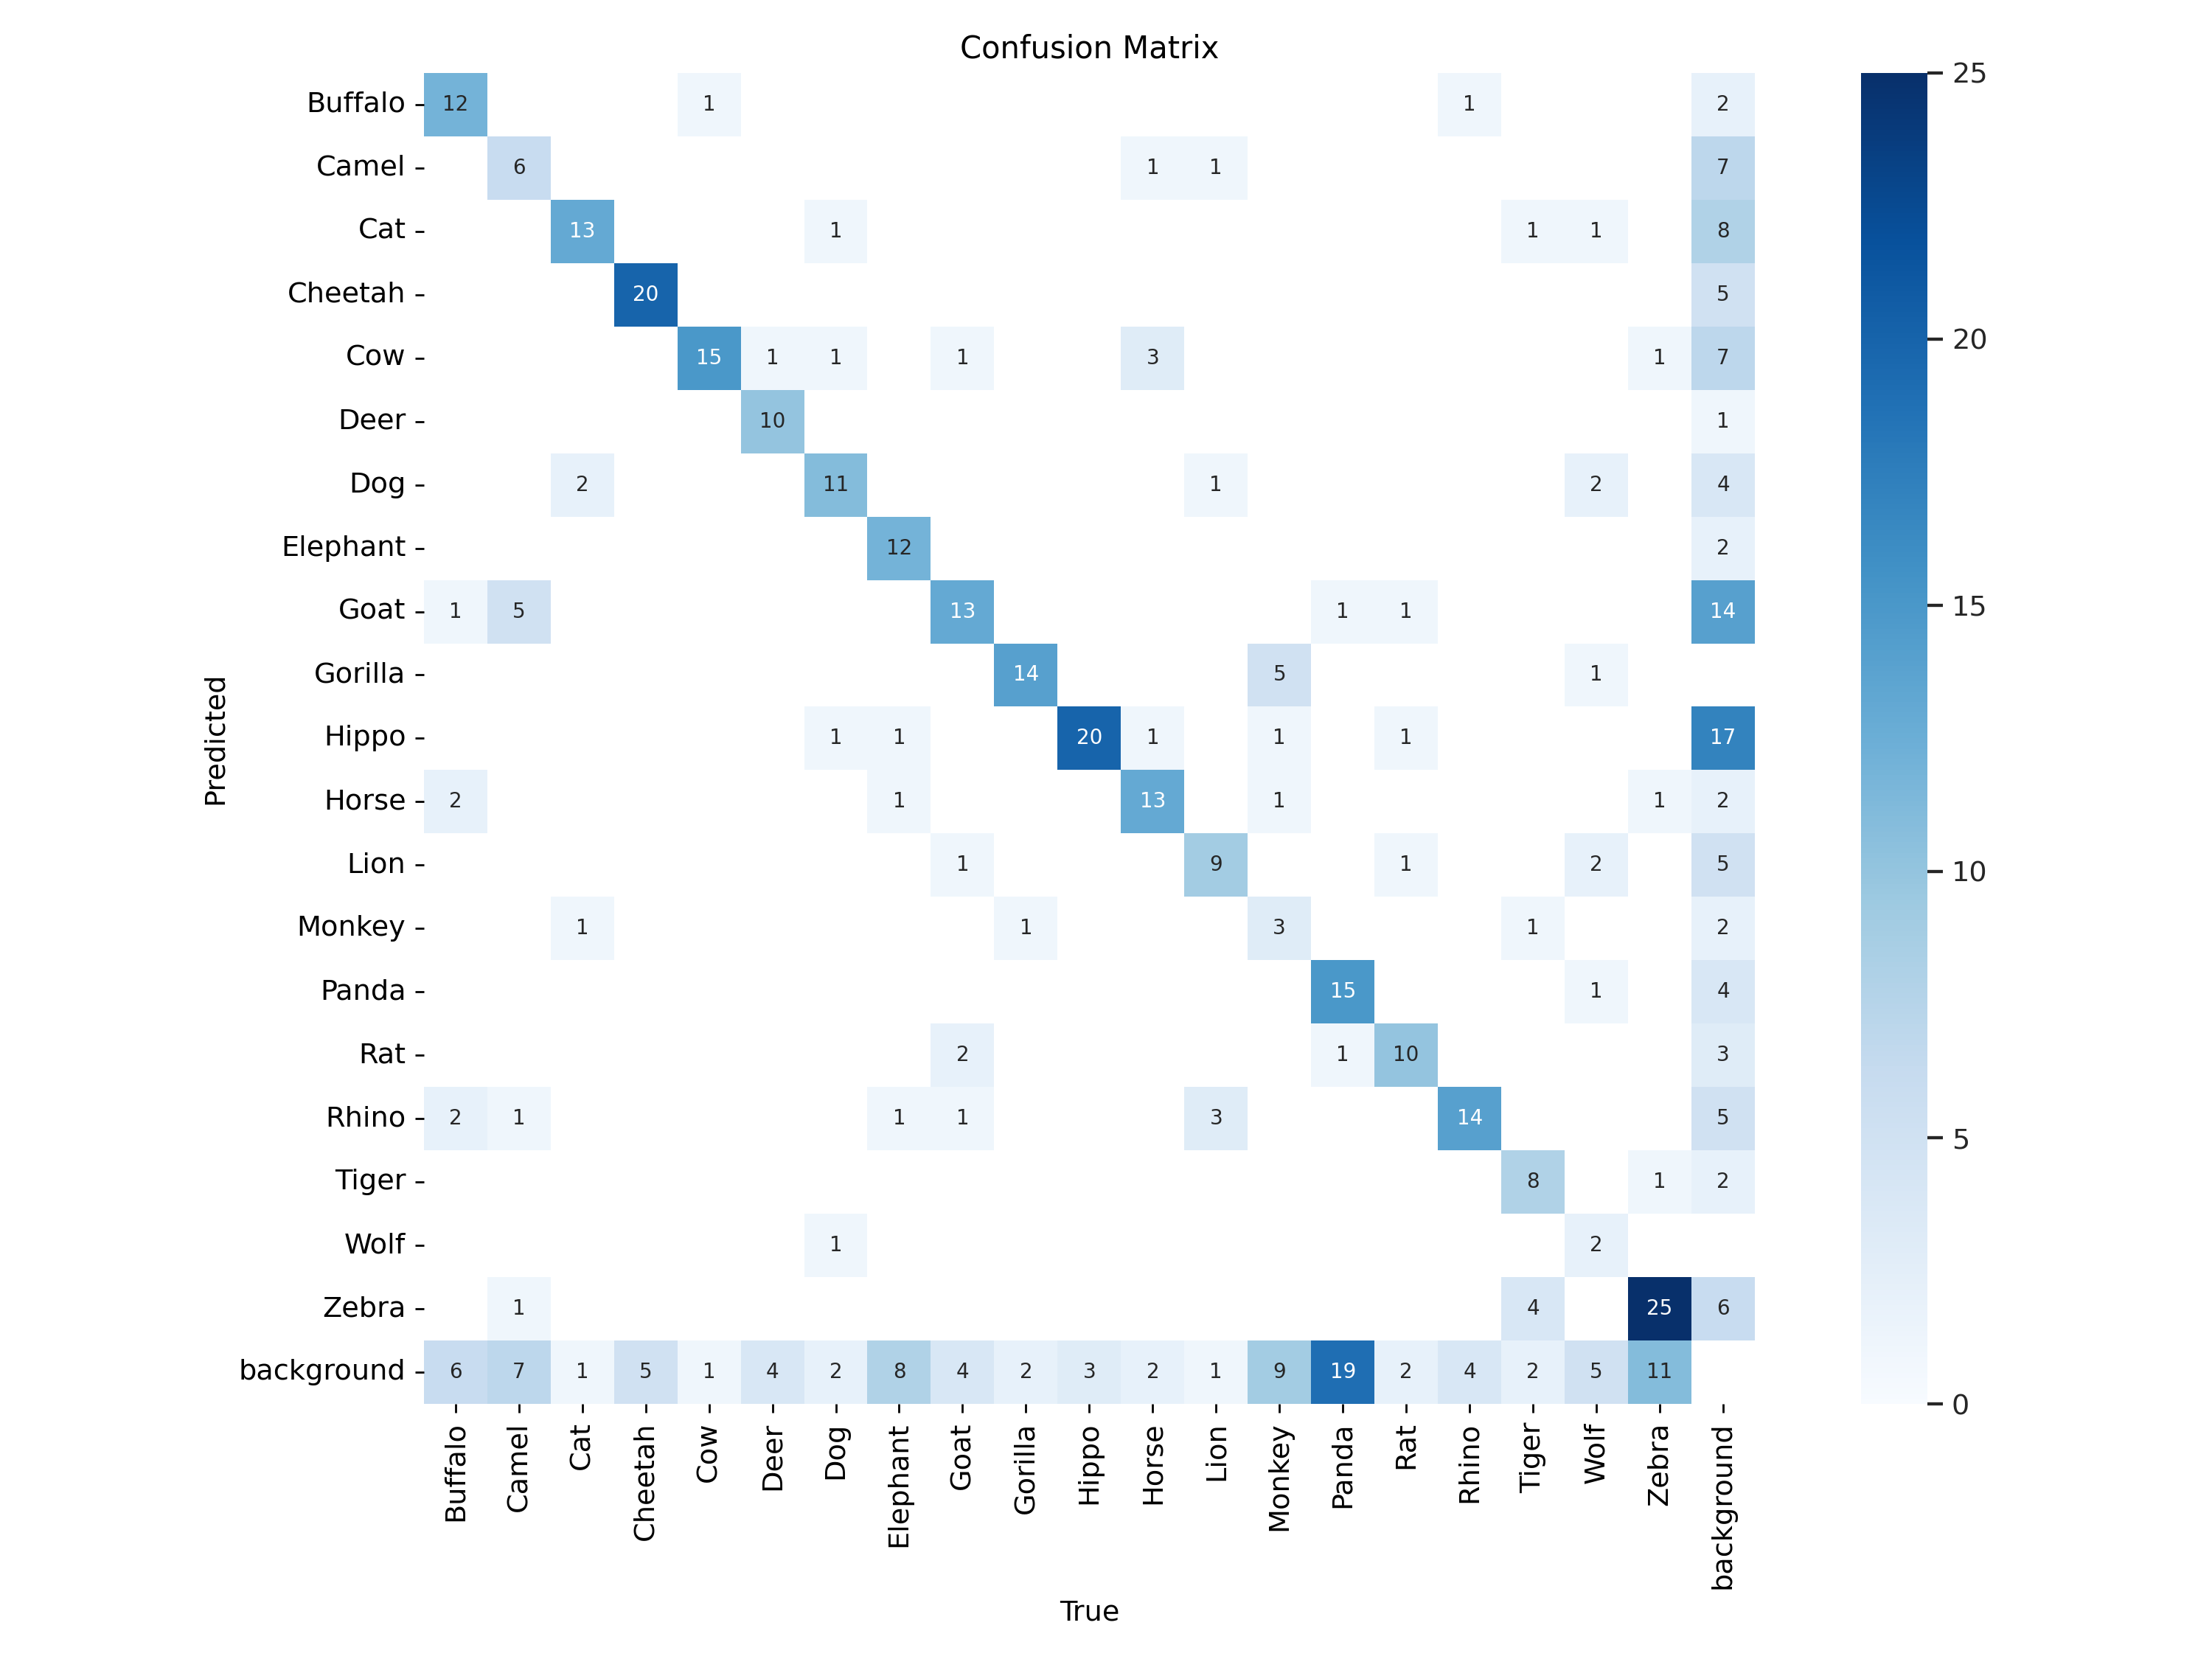

In [38]:
Image.open(f'{ROOT_DIR}/runs/detect/train/confusion_matrix.png')

## 3.4. Validación.

In [39]:
results = model.val(data=YAML_PATH, imgsz=IMAGE_SIZE, name="val")

Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/multiclass-animal-detection-Cleaned/labels/val.cache... 300 images, 1 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.75it/s]


                   all        300        412      0.682      0.616      0.706      0.482
               Buffalo         15         23      0.828      0.565      0.684      0.477
                 Camel         15         20      0.497      0.346       0.39      0.225
                   Cat         15         17      0.591      0.824      0.818      0.558
               Cheetah         15         25      0.826      0.759      0.807      0.456
                   Cow         15         17      0.578      0.882      0.848      0.578
                  Deer         15         15      0.977        0.6      0.743      0.546
                   Dog         15         17      0.749      0.824      0.823       0.57
              Elephant         15         23      0.785      0.522      0.703      0.511
                  Goat         15         22      0.536      0.727      0.725      0.502
               Gorilla         15         17      0.652      0.765      0.701       0.56
                 Hipp

Ten en cuenta la ruta de resultados de cada proceso de Yolo.

Todos los modelos cuentan con métricas, para el caso de Yolo, en este momento ya vamos viendo las siguientes 2:

***mAP50***: Esta es la precisión promedio calculada en un umbral de IoU (Intersección sobre Unión). En otras palabras, si la superposición entre la caja del objeto predicho y la caja del objeto real es al menos del 50%, entonces se considera una detección correcta.

***mAP50-95***: Esta es una métrica oficial de COCO que calcula el mAP para un rango de umbrales IoU desde 0.5 hasta 0.95 con un paso de 0.053. En otras palabras, calcula el mAP en umbrales IoU de 0.5, 0.55, 0.6, …, hasta 0.95 y luego toma el promedio3. Esta métrica es más rigurosa y proporciona una mejor indicación del rendimiento del modelo en diferentes niveles de superposición entre las cajas predichas y las reales3.

¿Qué tan bueno fue el proceso?

Ahora una muestra con  los elementos de validación, los objetos detectados:

In [40]:
Image.open(f'{ROOT_DIR}/runs/detect/val/val_batch0_pred.jpg')

Output hidden; open in https://colab.research.google.com to view.

## 3.4. Predicción.

Este siguiente comando ejecutará la `inferencia` en todas las imágenes de prueba utilizando tu modelo entrenado . El argumento `conf` permite establecer el umbral de confianza para las detecciones, por esta razón establecemos un 25%.

In [41]:
results = model.predict(source=new_img_tvt_folders[2], conf=0.25, save=True, imgsz=IMAGE_SIZE, name="predict")


image 1/300 /content/multiclass-animal-detection-Cleaned/images/test/Elephant-1-_png.rf.197cced44d9cfaea3712a2c2bdf0a983.jpg: 640x640 2 Elephants, 7.3ms
image 2/300 /content/multiclass-animal-detection-Cleaned/images/test/Elephant-13-_jpeg.rf.94584f74c05165c2528ed4ec0ef91e6d.jpg: 640x640 1 Elephant, 8.5ms
image 3/300 /content/multiclass-animal-detection-Cleaned/images/test/Elephant-15-_jpeg.rf.bfa60d96a67a18ea411c08d75b3bac71.jpg: 640x640 1 Horse, 10.1ms
image 4/300 /content/multiclass-animal-detection-Cleaned/images/test/Elephant-19-_jpeg.rf.3d9be22392097794f1c9c78dbe168295.jpg: 640x640 1 Elephant, 9.3ms
image 5/300 /content/multiclass-animal-detection-Cleaned/images/test/Elephant-2-_png.rf.8a010600e8678c491e09eefd234aa333.jpg: 640x640 1 Elephant, 1 Rhino, 10.9ms
image 6/300 /content/multiclass-animal-detection-Cleaned/images/test/Elephant-20-_jpeg.rf.8e91845057253d08cf077ae5ad434aed.jpg: 640x640 1 Horse, 7.7ms
image 7/300 /content/multiclass-animal-detection-Cleaned/images/test/Elep

Verificamos los resultados obtenidos:

In [42]:
predict_path = f'{ROOT_DIR}/runs/detect/predict'

img_list = [filename for filename in os.listdir(predict_path)]
img_count = len(img_list)
print(f"El número total de imágenes es: {img_count}")

El número total de imágenes es: 300


In [43]:
img_fc_list = [osp.join(predict_path, filename) for filename in img_list]

In [44]:
random.shuffle(img_fc_list)

Visualizamos las imágenes con los ejes, para continuar comprendiendo el uso de los bounding box.

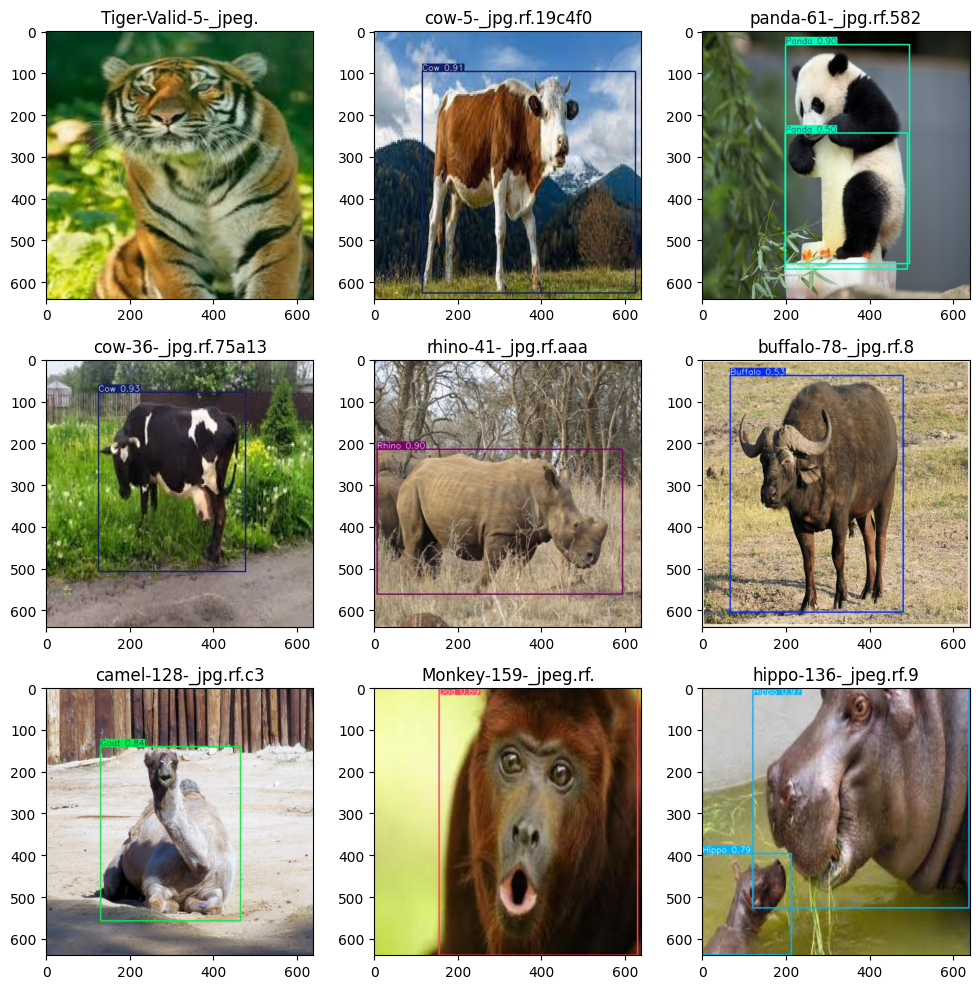

In [45]:
show_img_matrix(img_fc_list[0:9], show_axis=True)

---
# 4. Preguntas.

*  ¿Cómo puede modificar el hiperparámetro anchors en una red Yolo?.
*  ¿Los resultados pueden mejorarse?, p.e. número de épocas de entrenamiento, modificación de L1 y L2, ¿qué otros hiperparámetros podría considerar?.
*  ¿Sería necesario acudir a un proceso de aumentación de datos?, ¿mejoraría los resultados?.
*  ¿Qué otros hiperparámetros podrían ser ajustados?.
*  ¿Qué es el COCO dataset?
*  ¿Qué es y para qué sirve el mAP?.